<a href="https://colab.research.google.com/github/a-chow3/STAT4996/blob/main/Chow_4130_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STAT 4130 Final Project
Adam Chow


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change Working Directory
import os

os.chdir('/content/drive/MyDrive')

In [3]:
import pandas as pd

# Read in UVA Games File
uva_df = pd.read_csv("filtered_uva_games.csv")
uva_df['TaggedPitchType'] = uva_df['TaggedPitchType'].str.replace('ChangeUp', 'Changeup')
uva_df['ExitSpeed'] = uva_df['ExitSpeed'].fillna(0)

# Display the first 5 rows of the DataFrame
uva_df.head()

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,...,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2023-02-17,14:08:14,1,1,"Edgington, Brian",1.000027e+09,Right,VIR_CAV,"Burch, Nick",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
1,2,2023-02-17,14:08:35,1,2,"Edgington, Brian",1.000027e+09,Right,VIR_CAV,"Burch, Nick",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
2,3,2023-02-17,14:08:55,1,3,"Edgington, Brian",1.000027e+09,Right,VIR_CAV,"Burch, Nick",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
3,4,2023-02-17,14:09:14,1,4,"Edgington, Brian",1.000027e+09,Right,VIR_CAV,"Burch, Nick",...,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN
4,5,2023-02-17,14:09:35,1,5,"Edgington, Brian",1.000027e+09,Right,VIR_CAV,"Burch, Nick",...,NaN,NaN,High,High,High,High,High,NaN,NaN,NaN


### Create and Calculate PES

In [4]:
# Define Outcomes based on Run Value (Scaled up by 10 for interpretability)
def get_pitch_outcome_adjustment(row):
    adjustment = 0

    if row['PitchCall'] == 'StrikeSwinging':
        adjustment += 2.1  # Base value for a swinging strike
        if row['KorBB'] == 'Strikeout':
            adjustment += 2.7  # Additional value for completing the strikeout
    elif row['PitchCall'] == 'StrikeCalled':
        adjustment += 1.4  # Base value for a called strike
        if row['KorBB'] == 'Strikeout':
            adjustment += 2.7  # Additional value for completing the strikeout
    elif row['PitchCall'] == 'FoulBall':
        adjustment += 0.9  # Foul balls
    elif row['PitchCall'] == 'Ball':
        adjustment -= 1.0  # Base negative value for a ball
        if row['KorBB'] == 'Walk':
            adjustment -= 3.7  # Additional negative value for completing the walk
    elif row['PitchCall'] == 'HitByPitch':
        adjustment -= 3.7  # Hit by pitch (treated similarly to a walk)
    elif row['PitchCall'] == 'InPlay':
        if row['PlayResult'] == 'Out':
            adjustment += 2.7  # Out
        elif row['PlayResult'] == 'Single':
            adjustment -= 4.7  # Single
        elif row['PlayResult'] == 'Double':
            adjustment -= 7.8  # Double
        elif row['PlayResult'] == 'Triple':
            adjustment -= 10.2  # Triple
        elif row['PlayResult'] == 'HomeRun':
            adjustment -= 14.0  # Home run

    return adjustment

def get_exit_velocity_adjustment(row):
    if row['ExitSpeed'] < 80:
        return 2.0  # Weak contact
    elif row['ExitSpeed'] >= 95:
        return -0.5  # Hard contact
    return 0

In [5]:
def calculate_pes(row):
    base_score = 100
    pitch_outcome_adj = get_pitch_outcome_adjustment(row)
    exit_velocity_adj = get_exit_velocity_adjustment(row)

    return base_score + pitch_outcome_adj + exit_velocity_adj

uva_df['PES'] = uva_df.apply(calculate_pes, axis=1)

# Mean and SD
league_average_pes = uva_df['PES'].mean()
league_average_pes_sd = uva_df['PES'].std()

# Add Standardized Values to New Column
uva_df['StandardizedPES'] = 100 + (uva_df['PES'] - league_average_pes)
uva_df['StandardizedPES'] = uva_df['StandardizedPES'].round(2)

print(f"League Average PES: {league_average_pes}")

print(f"League Average PES SD: {league_average_pes_sd}")

League Average PES: 102.32754363558962
League Average PES SD: 2.7844946634884185


## Principal Component Analysis (PCA)

**Purpose and Application:**
- **Dimensionality Reduction:** PCA reduces the dimensionality of a dataset while preserving as much variance as possible. This is particularly useful when dealing with datasets that have many variables, some of which might be redundant or irrelevant.
- **Pattern Recognition:** PCA helps identify underlying patterns in the data by transforming the original variables into a new set of uncorrelated variables called principal components. These components are ordered by the amount of variance they capture from the data.

**Mathematical Understanding:**
1. **Standardization:** The first step in PCA is to standardize the data if the variables are on different scales.
2. **Covariance Matrix Calculation:** Compute the covariance matrix to understand how variables relate to each other.
3. **Eigenvalues and Eigenvectors:** Calculate eigenvalues and eigenvectors of the covariance matrix. Eigenvectors determine the direction of the new feature space, and eigenvalues indicate their magnitude (importance).
4. **Principal Components:** Select principal components based on eigenvalues. Typically, components with higher eigenvalues are chosen as they explain more variance.
5. **Transformation:** Transform the original dataset into the new feature space defined by the selected principal components.

**Advantages of PCA:**
- Simplifies complex datasets by reducing dimensions.
- Helps in noise reduction and improving model performance.
- Facilitates visualization of high-dimensional data.

## Why MANOVA is Less Useful in This Case

**Purpose of MANOVA:**
- MANOVA is used to assess whether there are any statistically significant differences between the means of multiple dependent variables across different groups.

**Limitations for Your Project:**
- **Assumptions:** MANOVA requires assumptions such as multivariate normality and homogeneity of variance-covariance matrices, which might not hold in your dataset.
- **Focus on Group Differences:** MANOVA is more suited for hypothesis testing about group differences rather than exploring data structure or reducing dimensions.


In [6]:
# Manual Calculation of PCA
import pandas as pd
import numpy as np

# Prepare Data to specify numerical columns to keep for PCA
selected_cols = ["PAofInning", "PitchofPA", "Balls", "Strikes",
                 "RelSpeed", "VertRelAngle", "HorzRelAngle", "SpinRate", "SpinAxis",
                 "RelHeight", "RelSide", "Extension", "VertBreak", "InducedVertBreak",
                 "HorzBreak", "PlateLocHeight", "PlateLocSide", "ZoneSpeed",
                 "VertApprAngle", "HorzApprAngle", "ZoneTime", "pfxx", "pfxz"]
X = uva_df[selected_cols].replace([np.inf, -np.inf], np.nan).dropna() # remove rows with inf or NaN values

# Standardize the features
def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std # Ensures that each feature will have a mean = 0, sd = 1

X_standardized = standardize(X)

# Compute the Covariance Matrix
def compute_covariance_matrix(X):
    n = X.shape[0]
    return (1 / (n-1)) * (X.T @ X) # Covariance matrix will will relate each variable ot the rest

cov_matrix = compute_covariance_matrix(X_standardized)

# Compute Eigen values and Eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Sort
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Compute Explained Variance Ratio
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1 # Num of Componentsneeded to explain 95% of variance
print(f"Number of components for 95% variance: {n_components}")

PC = X_standardized @ eigenvectors[:, :n_components]
print(PC.head(11))

Number of components for 95% variance: 11
          0         1         2         3         4         5         6   \
0   3.103093 -0.125176 -0.203930 -1.915758  0.650919  1.213633  0.252370   
1  -3.505361  0.739583 -1.699300 -1.191658 -1.423693  0.617265  0.565811   
2   3.382994 -0.169437 -1.317911 -0.458886 -1.578785  0.806420  0.753981   
3   3.487112 -0.314437 -0.720570  0.836934 -0.392166  1.187868  0.389276   
4   3.269295 -0.481079 -1.637092  1.579942 -1.258211  0.926805  0.674751   
5  -3.660126  1.173674 -1.804027 -2.132131 -0.190624  0.245933  0.322078   
6   3.413295 -0.319573 -1.220189 -1.383895 -0.734683  0.880254  0.347606   
7   3.225862 -0.403114 -0.655032  0.047875  0.819513  0.680377  0.229489   
8  -0.847896 -1.668455  3.295252  2.072011  0.083396 -0.819699  0.162600   
9   0.113455 -1.628183  0.011166  1.159052 -3.156312 -1.165450  0.963367   
10  3.179005 -0.286036 -1.834005  2.619293 -0.120171  0.503646  0.183657   

          7         8         9         10  


The matrix from my output above, represents the **Principal Component Scores**. Each row corresponds to an observation from the standardized dataset `X_standardized`, and each column corresponds to a principle component. For example, Column 0 represents the values for the first principal component (PC1). These principal components are ordered such that the first principal component explains the highest variance in the data, the second explains the next highest variance, and so on. The produced values in the matrix are the **coordinates of the observations in the new reduced-dimensional space**. For example, the value at row 0, column 0 (3.103093) is the score of the first observation on PC1.

In your case, the **first 11 components** can explain 95% of the variance in the data, which indicates that the original 23 variables can effectively be reduced to 11 dimensions without significant information loss.

In [7]:
# Compute eigenvalues and eigenvectors
def compute_eigen(X):
    cov_matrix = compute_covariance_matrix(X)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    idx = eigenvalues.argsort()[::-1]  # Sort by eigenvalue magnitude in descending order
    return eigenvalues[idx], eigenvectors[:, idx]

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = compute_eigen(X_standardized)

# Get the absolute magnitude of the eigenvectors (loadings)
loadings = np.abs(eigenvectors)  # Take absolute value to focus on magnitude

# Find the top contributing variable(s) for each principal component
top_contributors = {}
for i in range(loadings.shape[1]):  # Iterate over each principal component
    # Find the index of the variable with the highest loading
    max_index = np.argmax(loadings[:, i])
    top_contributors[f"PC{i+1}"] = {
        "Variable": selected_cols[max_index],
        "Contribution": loadings[max_index, i]
    }

# Print results
for pc, details in top_contributors.items():
    print(f"{pc}: Variable = {details['Variable']}, Contribution = {details['Contribution']:.4f}")

PC1: Variable = VertBreak, Contribution = 0.3675
PC2: Variable = pfxx, Contribution = 0.4632
PC3: Variable = HorzApprAngle, Contribution = 0.5576
PC4: Variable = PitchofPA, Contribution = 0.6209
PC5: Variable = PlateLocHeight, Contribution = 0.5725
PC6: Variable = Extension, Contribution = 0.5496
PC7: Variable = PAofInning, Contribution = 0.7672
PC8: Variable = RelHeight, Contribution = 0.4918
PC9: Variable = PlateLocSide, Contribution = 0.5679
PC10: Variable = Balls, Contribution = 0.5522
PC11: Variable = Extension, Contribution = 0.5540
PC12: Variable = SpinRate, Contribution = 0.5199
PC13: Variable = SpinAxis, Contribution = 0.7511
PC14: Variable = PitchofPA, Contribution = 0.7599
PC15: Variable = RelSpeed, Contribution = 0.7716
PC16: Variable = ZoneTime, Contribution = 0.6190
PC17: Variable = pfxx, Contribution = 0.6185
PC18: Variable = pfxz, Contribution = 0.6068
PC19: Variable = VertApprAngle, Contribution = 0.6792
PC20: Variable = RelSide, Contribution = 0.6502
PC21: Variable = 

In each of the first three PC's, each of htese variables contribute to how the ball moves or how it is percieved to move, since pfxx tells us how much a singular pitch moved in the last 40 feet to the plate.

In [8]:
# Built-in function of PCA
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Prepare Data to specify numerical columns to keep for PCA
selected_cols = ["PAofInning", "PitchofPA", "Balls", "Strikes",
                 "RelSpeed", "VertRelAngle", "HorzRelAngle", "SpinRate", "SpinAxis",
                 "RelHeight", "RelSide", "Extension", "VertBreak", "InducedVertBreak",
                 "HorzBreak", "PlateLocHeight", "PlateLocSide", "ZoneSpeed",
                 "VertApprAngle", "HorzApprAngle", "ZoneTime", "pfxx", "pfxz"]
X = uva_df[selected_cols]


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Impute NaN values with the mean of each column before performing PCA
# This replaces all NaN values in X_scaled with the mean of their respective columns
# You can also explore other imputation strategies like using the median or a constant value
np.nan_to_num(X_scaled, copy=False)

# Perform PCA using hte built in Python Funciton
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

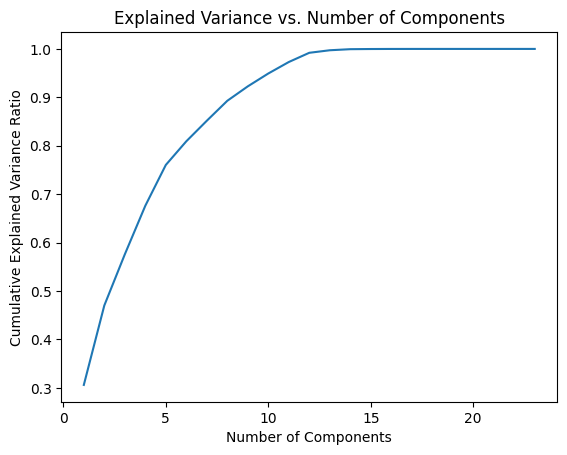

In [9]:
# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Components')
plt.show()

In [10]:
# Determine number of components for 95% variance
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1

# Perform PCA with selected number of components
pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

# Get feature importance
feature_importance = np.abs(pca_final.components_).sum(axis=0)
feature_importance = 100 * feature_importance / feature_importance.sum()
important_features = pd.DataFrame({'feature': selected_cols, 'importance': feature_importance})
important_features = important_features.sort_values('importance', ascending=False)

print(f"Number of components for 95% variance: {n_components}")
print("\nTop 11 most important features:")
print(important_features.head(11))

Number of components for 95% variance: 11

Top 11 most important features:
           feature  importance
11       Extension    7.217611
16    PlateLocSide    6.677722
9        RelHeight    6.533719
7         SpinRate    6.058956
0       PAofInning    5.819099
3          Strikes    5.546843
2            Balls    5.513434
15  PlateLocHeight    5.410038
10         RelSide    4.856872
8         SpinAxis    4.774666
19   HorzApprAngle    4.094168


As we can see from the built-in code, the Number of components for 95% variance for hte dataframe is the same as the manual calculation.

#### Interpretation:

Out of my 23 numeric variables, we can reduce the dimensionality to 11 principal components while still retaining 95% of the original variability in the data.

This reduction of the dimensionality of my dataset allows me to focus on the most significant aspects of my data to make it easier to analyze and interpret. In essence, the reduced dataset will still be able to accurately reflect the significant characteristics and patterns present in the original dataset, while eliminating the irrelevant noise that otherwise might disrupt the patterns of the dataset.


The importance table I produced represents the relative percent contribution of the total variance captured by the principal components.

We can clearly see that Extension, PlateLocSide, RelHeight, SpinRate, and PAofInning, are the top five contributors to the variation in the data. This conclusion suggests that these variables are particularly important in distinguishing different pitches.

SpinRate and PlateLocSide are obvious indicators of this distiguishability, but PAofInning and release point data were intruiging to identify as important factors. It is clear that our UVA pitchers have tendencies to throw specific pitches to different parts of the batting order. The significant reduction own to 11 variables indicates that we have some redundancy or correlation in our original variables.


These percentages allow us to compare the relative importance of variables. For example, Extension contributes about 1.1 times more to the variance than PlateLocSide (7.22% vs 6.68%).

# Linear Discriminant Analysis

For my next goal, I wanted to analyze what statistics were important to focus on when attempting to identify what qualities correlate with a successful pitch. For this goal I chose Linear Discriminant Analysis over another another method like Canonical Correlation Analysis.

CCA is often used to analyze relationships between sets of variables - numeric columns in my uva_df. CCA i intuitively less directly applicable to classifying pitch effectiveness in my situation. CCA would be more appropriate if I was trying to understand the relationships between different sets of variables like pitching and hitting for instance.

Linear Discriminant Analysis was chosen in this situation because its purpose is to find a linear combination of features that maximizes the separation between classes while minimizing the variation within each class. This directly applies to pitch optimization where we hope to distinguish good pitches from bad ones and assess what features make up these categories.

For the sake of coding space, I have elected to use he built in LDA function. However, in this function, it will preform the following steps to reduce the dimensions:

1. Compute the mean vectors for each class:
$$
\mu_k = \frac{1}{n_k} \sum_{i=1}^{n_k} x_i
$$

where $ x_i $ are the samples in class k, and $ n_k $ is the number of samples in class k.

2. Next, calculate the within-class scatter matrix that represents the spread of samples around their respective class means:
$$
S_W = \sum_{k=1}^{c} \sum_{i=1}^{n_k} (x_i - \mu_k)(x_i - \mu_k)^T
$$

3. Then, calculate the between-class scatter matrix that represents the spread of class means around the overall mean:
$$
S_B = \sum_{k=1}^{c} n_k(\mu_k - \mu)(\mu_k - \mu)^T
$$

where $ \mu $ represents the overall mean.

4. Solve the generalized eigenvalue problem that finds the directions that maximize between-class variance while minimizing within-class variance:
$$
S_W^{-1}S_B v = \lambda v
$$

5. Then, use these largest found eigenvectors to form the final transformation matrix W:
$$
y = W^T x
$$

In [11]:
# Define unique values for each categorical column
pitcher_throws_values = uva_df['PitcherThrows'].unique()
batter_side_values = uva_df['BatterSide'].unique()
tagged_pitch_type_values = uva_df['TaggedPitchType'].unique()

# Create an empty dictionary to store the subset DataFrames
subset_dfs = {}

# Iterate through all combinations of categorical values
for pitcher_throws in pitcher_throws_values:
    for batter_side in batter_side_values:
        for tagged_pitch_type in tagged_pitch_type_values:
            # Create a DataFrame name based on the combination
            df_name = f"{pitcher_throws[0]}{batter_side[0]}_{tagged_pitch_type}"

            # Filter the original DataFrame to create the subset
            subset_dfs[df_name] = uva_df[
                (uva_df['PitcherThrows'] == pitcher_throws) &
                (uva_df['BatterSide'] == batter_side) &
                (uva_df['TaggedPitchType'] == tagged_pitch_type)
            ]

pitch_types = ['Fastball', 'Slider', 'Splitter', 'Changeup', 'Curveball', 'Undefined', 'Cutter', 'Sinker']
handedness = ['RR', 'RL', 'LR', 'LL']

for hand in handedness:
    for pitch in pitch_types:
        key = f"{hand}_{pitch}"
        if key in subset_dfs:
            shape = subset_dfs[key].shape
            print(f"Shape of {key}: {shape}")
        else:
            print(f"{key} not found in the dictionary")

Shape of RR_Fastball: (435, 169)
Shape of RR_Slider: (262, 169)
Shape of RR_Splitter: (26, 169)
Shape of RR_Changeup: (56, 169)
Shape of RR_Curveball: (87, 169)
Shape of RR_Undefined: (73, 169)
Shape of RR_Cutter: (32, 169)
Shape of RR_Sinker: (53, 169)
Shape of RL_Fastball: (359, 169)
Shape of RL_Slider: (58, 169)
Shape of RL_Splitter: (19, 169)
Shape of RL_Changeup: (177, 169)
Shape of RL_Curveball: (30, 169)
Shape of RL_Undefined: (58, 169)
Shape of RL_Cutter: (0, 169)
Shape of RL_Sinker: (62, 169)
Shape of LR_Fastball: (230, 169)
Shape of LR_Slider: (19, 169)
Shape of LR_Splitter: (0, 169)
Shape of LR_Changeup: (108, 169)
Shape of LR_Curveball: (20, 169)
Shape of LR_Undefined: (32, 169)
Shape of LR_Cutter: (0, 169)
Shape of LR_Sinker: (0, 169)
Shape of LL_Fastball: (65, 169)
Shape of LL_Slider: (54, 169)
Shape of LL_Splitter: (0, 169)
Shape of LL_Changeup: (1, 169)
Shape of LL_Curveball: (18, 169)
Shape of LL_Undefined: (15, 169)
Shape of LL_Cutter: (0, 169)
Shape of LL_Sinker: (0,

In [12]:
# Cut down the List of subset_dfs to only include dfs with 15 or more rows
subset_dfs = {key: df for key, df in subset_dfs.items() if df.shape[0] >= 20}

# Cut down RR_Undefined, RL_Undefined, LR_Undefined, LL_Undefined
for key in ['RR_Undefined', 'RL_Undefined', 'LR_Undefined', 'LL_Undefined']:
    if key in subset_dfs:
        del subset_dfs[key]

In [13]:
# Cut down columns to only include numeric columns for analysis
for df_name, df in subset_dfs.items():
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    subset_dfs[df_name] = df[numeric_cols]

In [14]:
# Keep only selected columns to keep 95% of Variance
desired_columns = [
    'RelSpeed', 'SpinRate', 'SpinAxis',
    'InducedVertBreak', 'HorzBreak',
    'PlateLocHeight', 'PlateLocSide', 'VertApprAngle',
    'StandardizedPES' # Get rid of columns that cannot be controlled
]
# Get rid of EV, RelH, RelS, Ext, VRelAngle, Balls, Strikes

for df_name, df in subset_dfs.items():
    # Select only the desired columns that exist in the DataFrame
    existing_columns = [col for col in desired_columns if col in df.columns]

    # Keep only these columns in the DataFrame
    subset_dfs[df_name] = df[existing_columns]
    print(f"Shape of {df_name} after column selection: {subset_dfs[df_name].shape}")

Shape of RR_Fastball after column selection: (435, 9)
Shape of RR_Slider after column selection: (262, 9)
Shape of RR_Splitter after column selection: (26, 9)
Shape of RR_Changeup after column selection: (56, 9)
Shape of RR_Curveball after column selection: (87, 9)
Shape of RR_Cutter after column selection: (32, 9)
Shape of RR_Sinker after column selection: (53, 9)
Shape of RL_Fastball after column selection: (359, 9)
Shape of RL_Slider after column selection: (58, 9)
Shape of RL_Changeup after column selection: (177, 9)
Shape of RL_Curveball after column selection: (30, 9)
Shape of RL_Sinker after column selection: (62, 9)
Shape of LR_Fastball after column selection: (230, 9)
Shape of LR_Changeup after column selection: (108, 9)
Shape of LR_Curveball after column selection: (20, 9)
Shape of LL_Fastball after column selection: (65, 9)
Shape of LL_Slider after column selection: (54, 9)


## Preform LDA

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer # Import SimpleImputer
import numpy as np

# Iterate through subset DataFrames
for df_name, df in subset_dfs.items():
    # Check if the DataFrame is not empty
    if not df.empty:

        # Prepare data for the model
        X = df.drop('StandardizedPES', axis=1)
        y = df['StandardizedPES']  # Target variable (SPES)
        y = y.astype(int)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Impute missing values using the mean # New: Imputation step
        imputer = SimpleImputer(strategy='mean') # Create an imputer instance
        X_train = imputer.fit_transform(X_train) # Fit and transform on training data
        X_test = imputer.transform(X_test) # Transform testing data using the trained imputer

        # Standardize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fit LDA
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train_scaled, y_train)

        # Predict and evaluate
        y_pred = lda.predict(X_test_scaled)
        # Assuming 'features' is defined somewhere before this point
        features = X.columns # Get feature names from the DataFrame.
        feature_importance = dict(zip(features, abs(lda.coef_[0])))
        # Keep only features with importance greater than 10
        top_features = {k: v for k, v in feature_importance.items() if v > 1}

        # Removed 'return' to print inside the loop
        print(classification_report(y_test, y_pred), feature_importance)

        print(f"Results for {df_name}:")
        # 'mse' and 'r2' are not calculated, you'll need to add that logic.
        # print(f"Mean Squared Error: {mse}")
        # print(f"R-squared: {r2}")
        print(f"Important Features: {top_features}")
        print("-" * 20)  # Print a separator between results
    else:
        print(f"DataFrame {df_name} is empty. Skipping...")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

              precision    recall  f1-score   support

          83       0.00      0.00      0.00         3
          89       0.50      0.33      0.40         3
          92       0.00      0.00      0.00         5
          94       0.00      0.00      0.00         3
          95       0.00      0.00      0.00         1
          97       0.00      0.00      0.00         2
          98       0.00      0.00      0.00         7
          99       0.40      0.67      0.50        54
         100       0.14      0.14      0.14        22
         101       0.15      0.09      0.11        23
         102       0.00      0.00      0.00         5
         104       0.00      0.00      0.00         3

    accuracy                           0.32       131
   macro avg       0.10      0.10      0.10       131
weighted avg       0.23      0.32      0.26       131
 {'RelSpeed': 2.1817134856429687, 'SpinRate': 0.4150428118694867, 'SpinAxis': 0.2879069487694389, 'InducedVertBreak': 2.12154887758096

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

              precision    recall  f1-score   support

          83       0.00      0.00      0.00         1
          95       0.00      0.00      0.00         0
          99       0.50      0.29      0.36         7
         100       0.25      0.25      0.25         4
         101       0.50      0.40      0.44         5
         102       0.00      0.00      0.00         1
         104       0.00      0.00      0.00         0

    accuracy                           0.28        18
   macro avg       0.18      0.13      0.15        18
weighted avg       0.39      0.28      0.32        18
 {'RelSpeed': 5.192287096021677, 'SpinRate': 3.4918431092860667, 'SpinAxis': 0.9010895146890863, 'InducedVertBreak': 1.776514779090786, 'HorzBreak': 1.1892212466766194, 'PlateLocHeight': 1.0299276446235972, 'PlateLocSide': 1.3188309284421575, 'VertApprAngle': 3.1795931385582215}
Results for RL_Slider:
Important Features: {'RelSpeed': 5.192287096021677, 'SpinRate': 3.4918431092860667, 'InducedVertBreak

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

### LDA Results

| Matchup_Pitch | Most Important Factor |
|----------|:----------|
| RR_Fastball | |
| RR_Fastball | |
| RR_Fastball | |
| RR_Fastball | |
| RR_Fastball | |
| RR_Fastball | |
| RR_Fastball | |
| RL_Fastball | |
| RL_Fastball | |
| RL_Fastball | |
| RL_Fastball | |
| RL_Fastball | |
| LR_Fastball | |
| LR_Changeup | |
| LR_Curveball | |
| LL_Fastball | |
| LL_Slider | |

To draw some further conclusions from this LDA, we want to take a look at some specific variable outliers of importance in specific matchups to find what metrics we would want to emulate in our own pitchers.

## Application of LDA Results

#### Righty-Righty Fastball (Vertical Approach Angle)

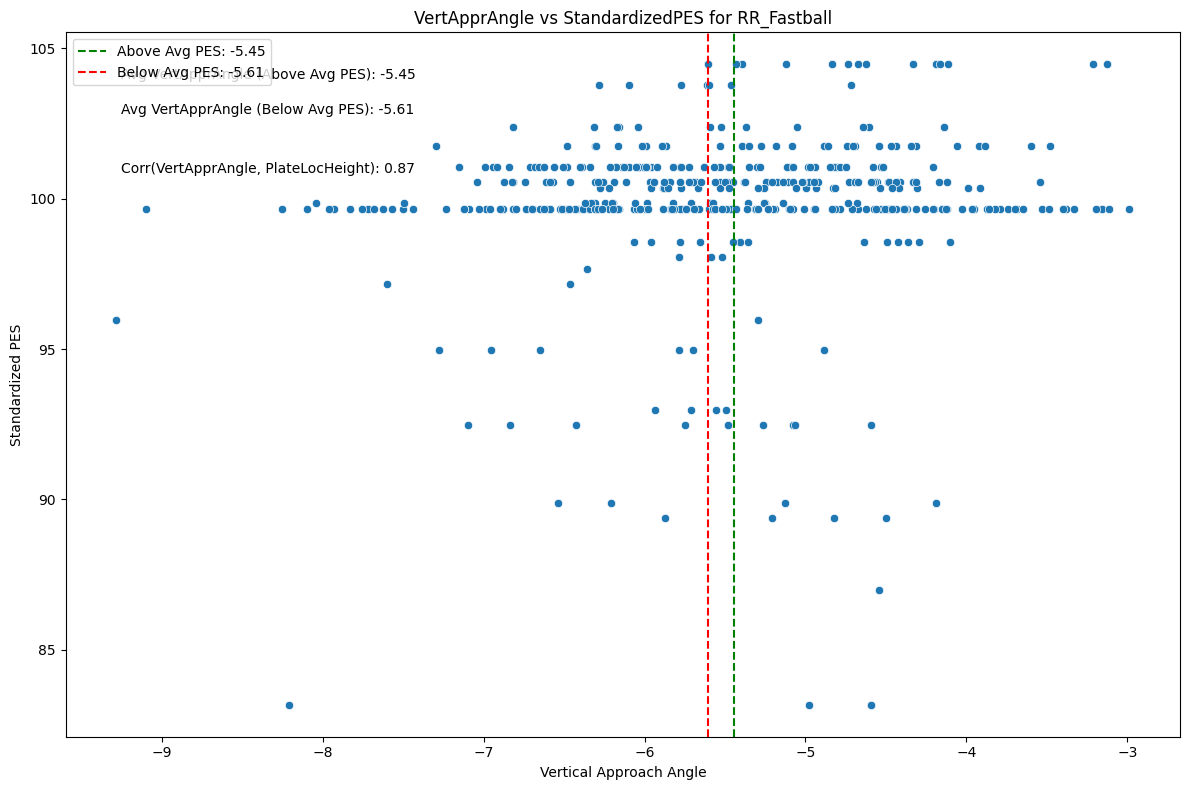

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RR_Fastball']

# Create the plot
plt.figure(figsize=(12, 8))

# Scatter plot of VertApprAngle vs StandardizedPES
sns.scatterplot(x='VertApprAngle', y='StandardizedPES', data=df)

# Calculate average VertApprAngle for above and below average PES
avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['VertApprAngle'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['VertApprAngle'].mean()

# Add lines for average VertApprAngle
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('VertApprAngle vs StandardizedPES for RR_Fastball')
plt.xlabel('Vertical Approach Angle')
plt.ylabel('Standardized PES')
plt.legend()

# Add text for average values
plt.text(0.05, 0.95, f'Avg VertApprAngle (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg VertApprAngle (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

# Calculate correlations
corr = df[['VertApprAngle', 'PlateLocHeight']].corr()

# Add correlation information
plt.text(0.05, 0.80, f'Corr(VertApprAngle, PlateLocHeight): {corr.loc["VertApprAngle", "PlateLocHeight"]:.2f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

- Flat angles
- Above 100 + Right of Green produces the highest density of plus pitches

#### Righty-Righty Slider (Plate Location Side)

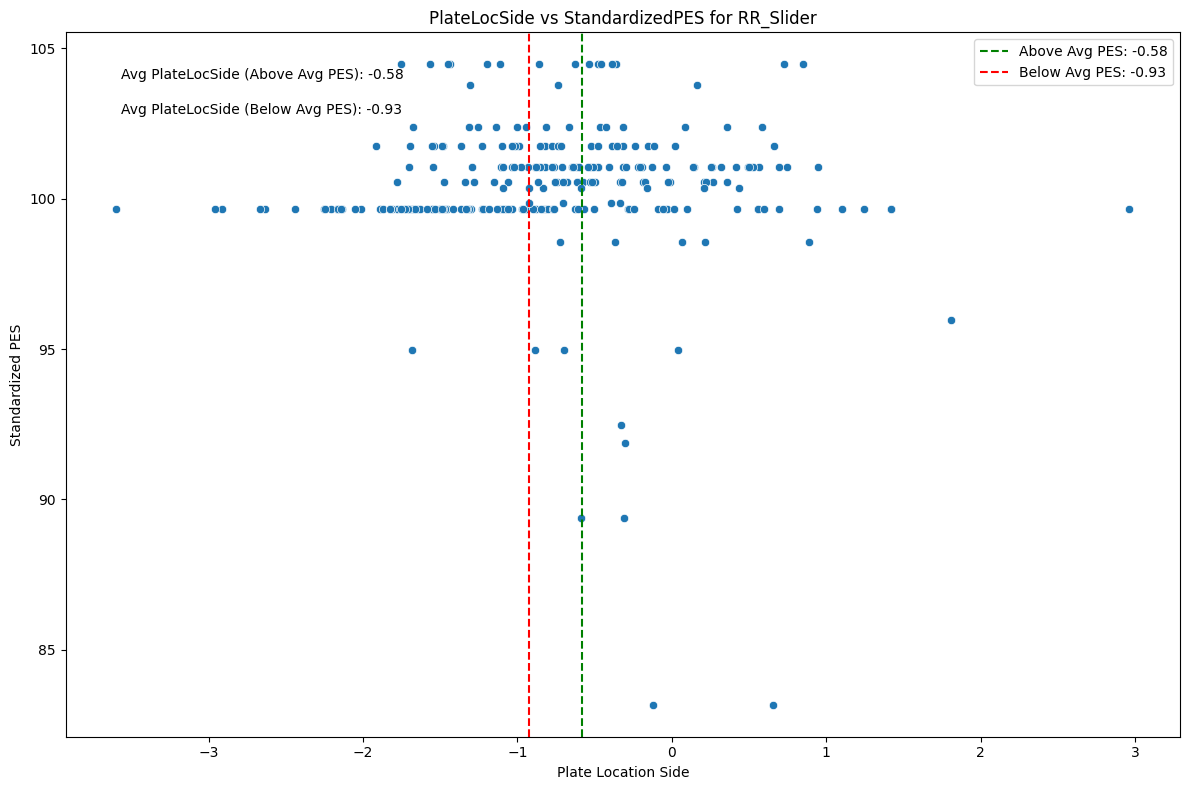

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RR_Slider']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='PlateLocSide', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['PlateLocSide'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['PlateLocSide'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('PlateLocSide vs StandardizedPES for RR_Slider')
plt.xlabel('Plate Location Side')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg PlateLocSide (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg PlateLocSide (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

#### Righty-Righty Slider (Spin Rate)

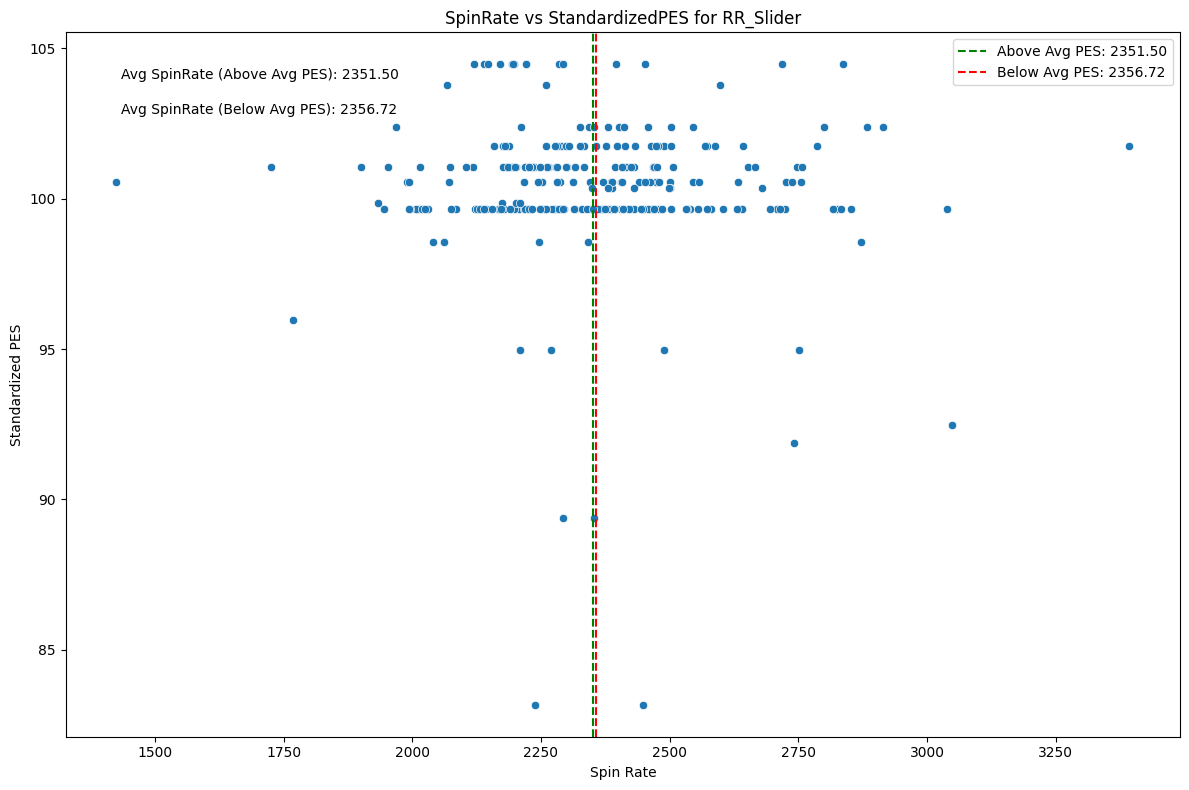

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RR_Slider']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='SpinRate', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['SpinRate'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['SpinRate'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('SpinRate vs StandardizedPES for RR_Slider')
plt.xlabel('Spin Rate')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg SpinRate (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg SpinRate (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

#### Righty-Righty Cutter (Plate Location Side)

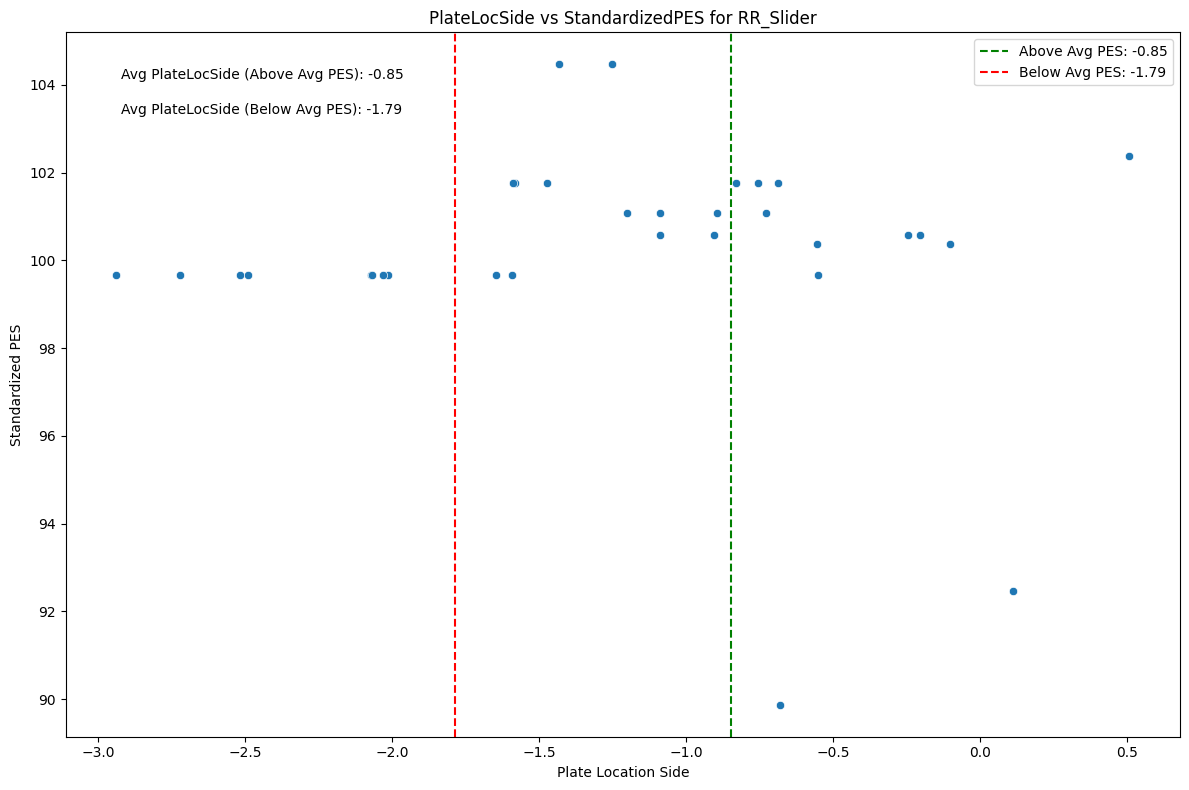

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RR_Cutter']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='PlateLocSide', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['PlateLocSide'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['PlateLocSide'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('PlateLocSide vs StandardizedPES for RR_Slider')
plt.xlabel('Plate Location Side')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg PlateLocSide (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg PlateLocSide (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

#### Righty-Righty Sinker (Induced Vertical Break)



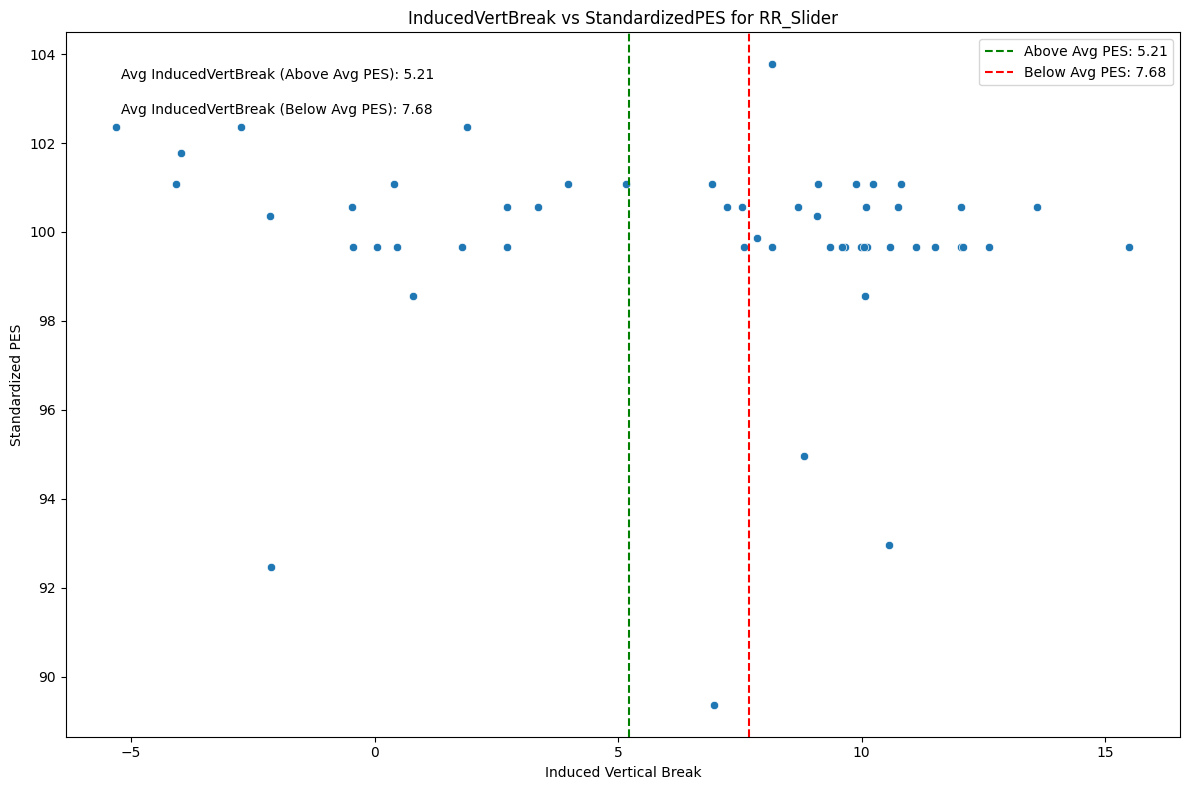

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RR_Sinker']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='InducedVertBreak', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['InducedVertBreak'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['InducedVertBreak'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('InducedVertBreak vs StandardizedPES for RR_Slider')
plt.xlabel('Induced Vertical Break')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg InducedVertBreak (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg InducedVertBreak (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

#### Righty-Lefty Fastball (Induced Vertical Break)


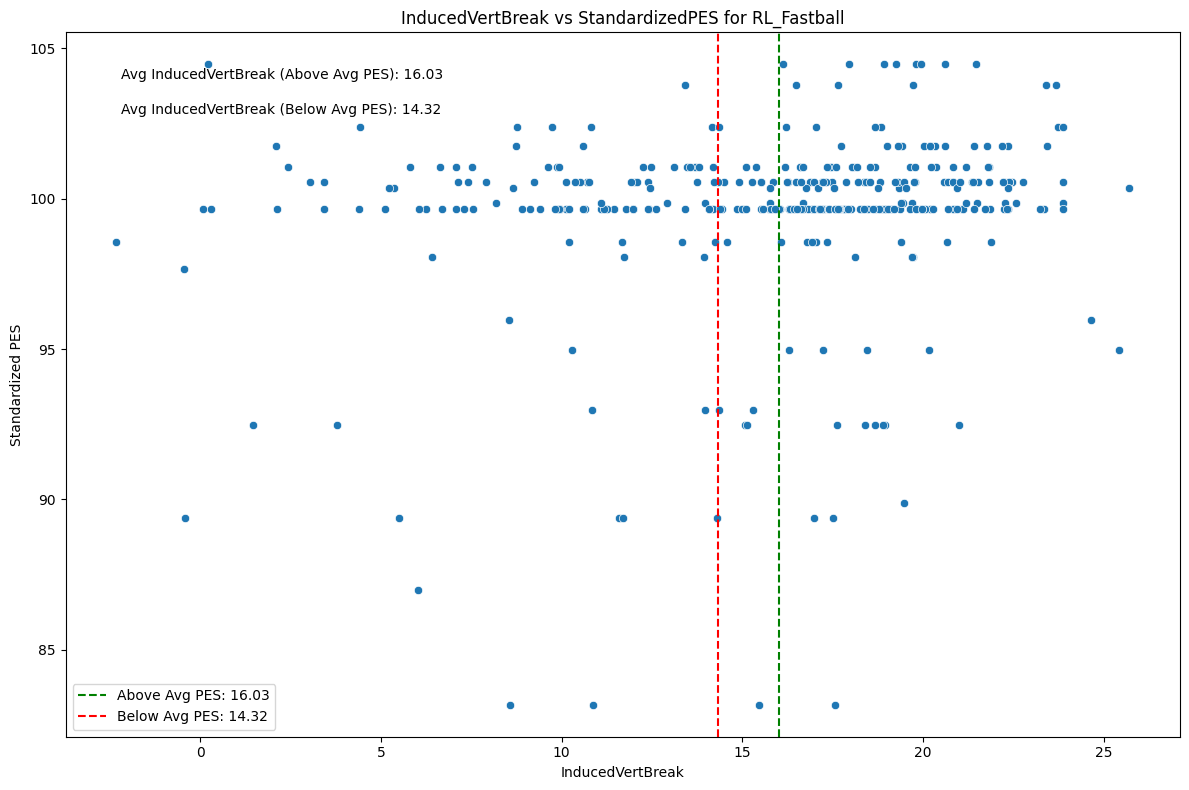

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RL_Fastball']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='InducedVertBreak', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['InducedVertBreak'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['InducedVertBreak'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('InducedVertBreak vs StandardizedPES for RL_Fastball')
plt.xlabel('InducedVertBreak')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg InducedVertBreak (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg InducedVertBreak (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

#### Righty-Lefty Slider

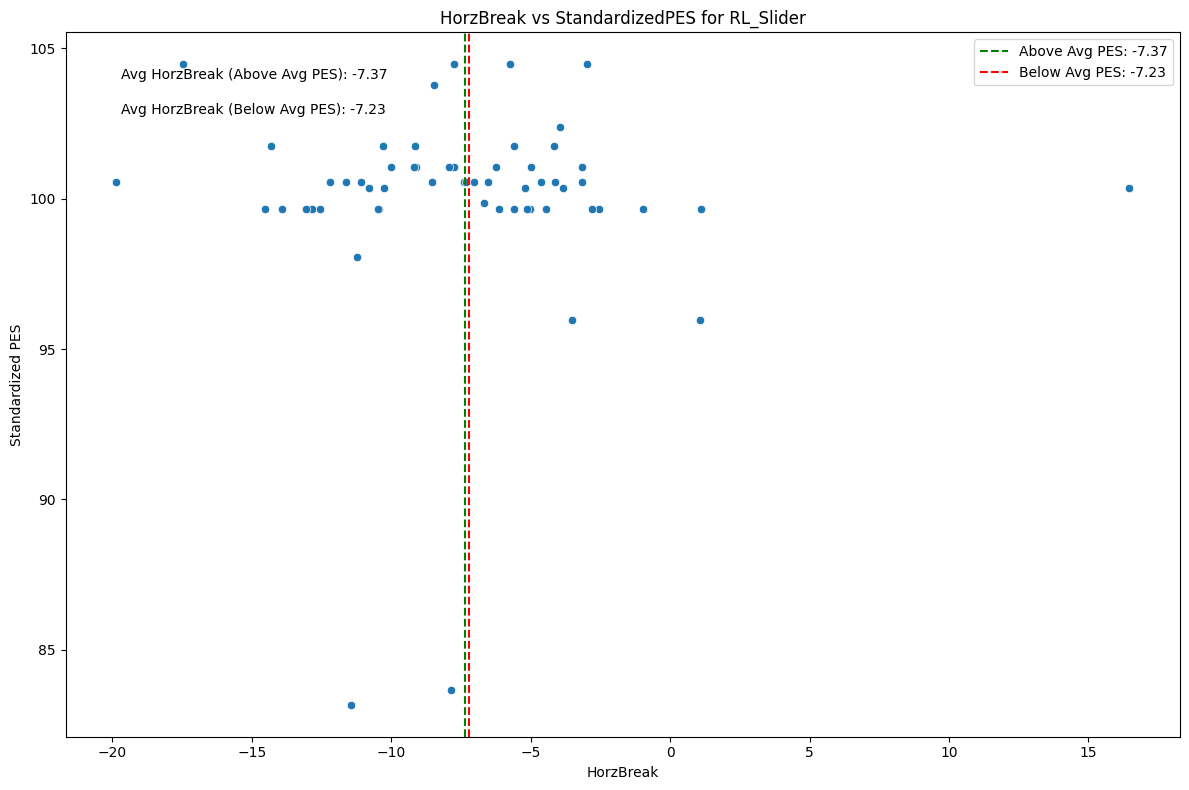

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RL_Slider']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='HorzBreak', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['HorzBreak'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['HorzBreak'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('HorzBreak vs StandardizedPES for RL_Slider')
plt.xlabel('HorzBreak')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg HorzBreak (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg HorzBreak (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

Looks like smaller breaking sliders have a smaller range of observed outcomes. These smaller breaking pitches will be faster. Let's see if this hold true when looking at speed (RelSpeed).
Also, it looks like RL Sliders are actually a good pitch (keep in mind small sample size). Let's also look at the location of these good outcomes to identify any trends

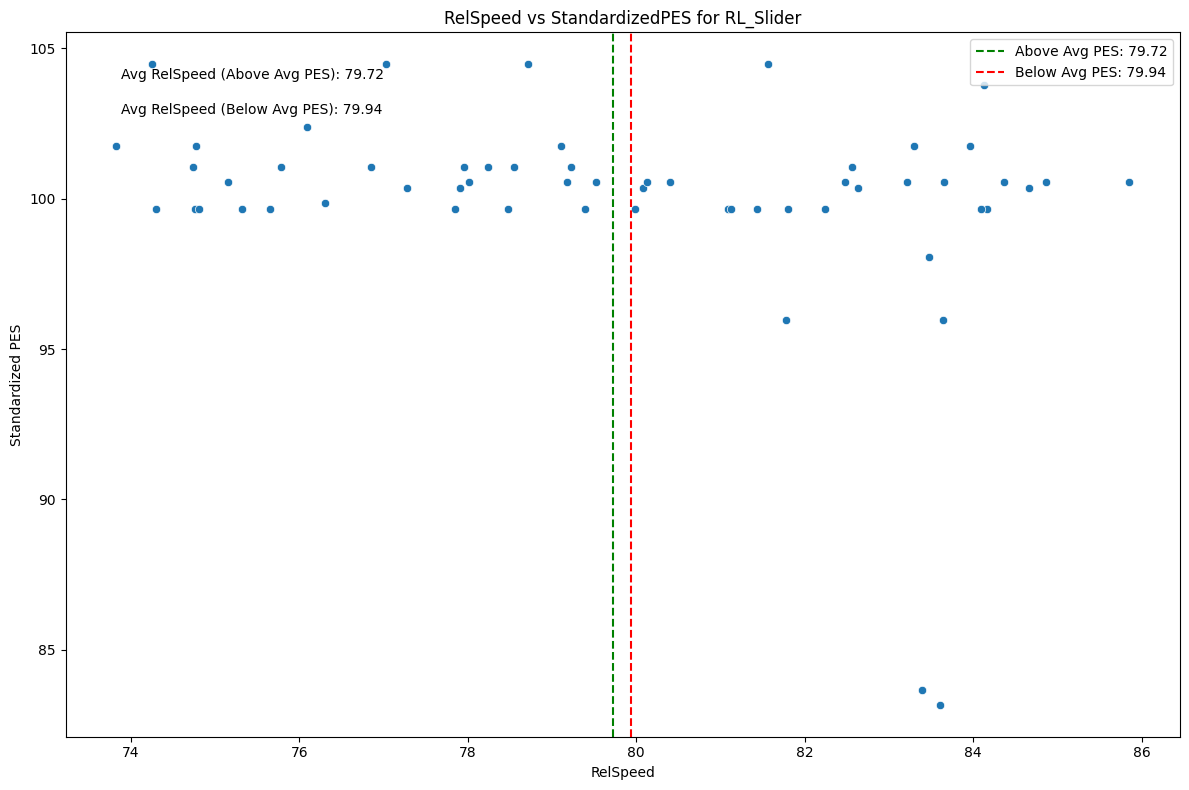

In [21]:
# Release Speed
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RL_Slider']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='RelSpeed', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['RelSpeed'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['RelSpeed'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('RelSpeed vs StandardizedPES for RL_Slider')
plt.xlabel('RelSpeed')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg RelSpeed (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg RelSpeed (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

Very interesting that these observed homeruns came against faster pitches and not hte slower ones. Slow, sweeping sliders were good against lefties? This is usually seen as a sin facing an opposite handed hitter, but I hypothesize that location plays a massive role in fooling the hitter.

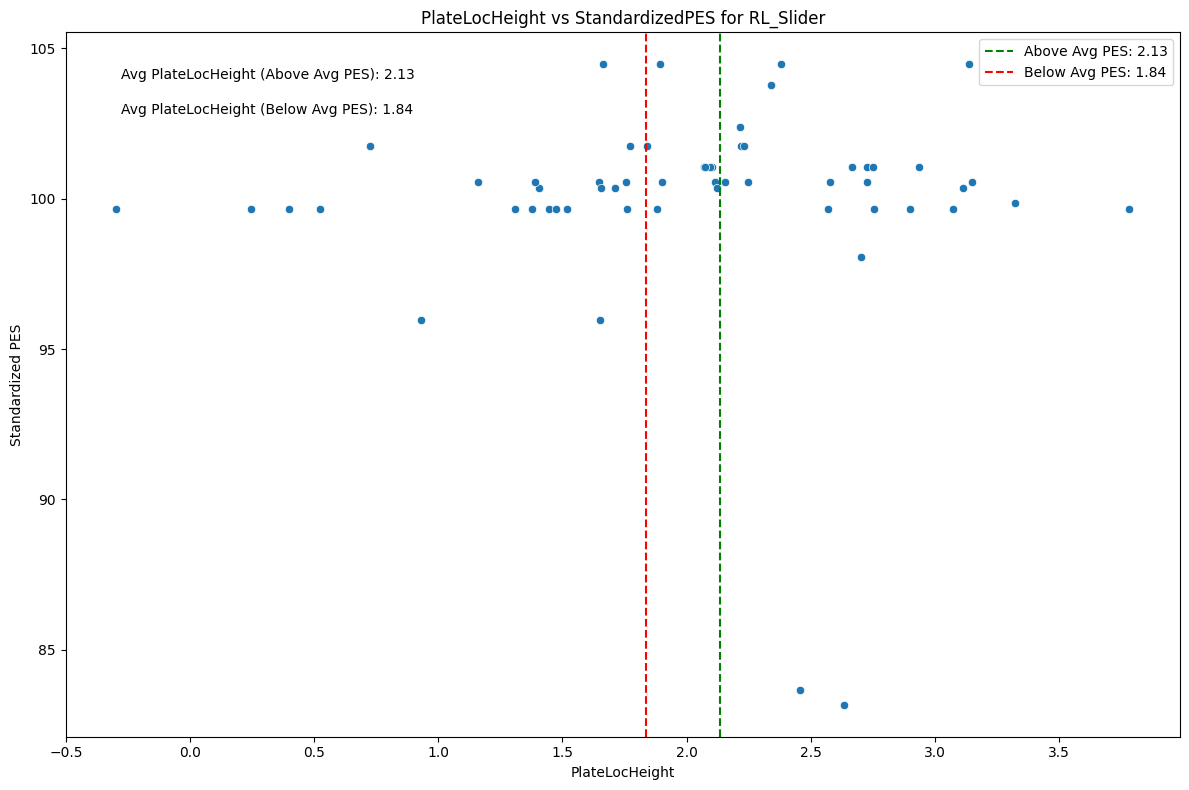

In [22]:
# Height Location
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RL_Slider']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='PlateLocHeight', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['PlateLocHeight'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['PlateLocHeight'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('PlateLocHeight vs StandardizedPES for RL_Slider')
plt.xlabel('PlateLocHeight')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg PlateLocHeight (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg PlateLocHeight (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

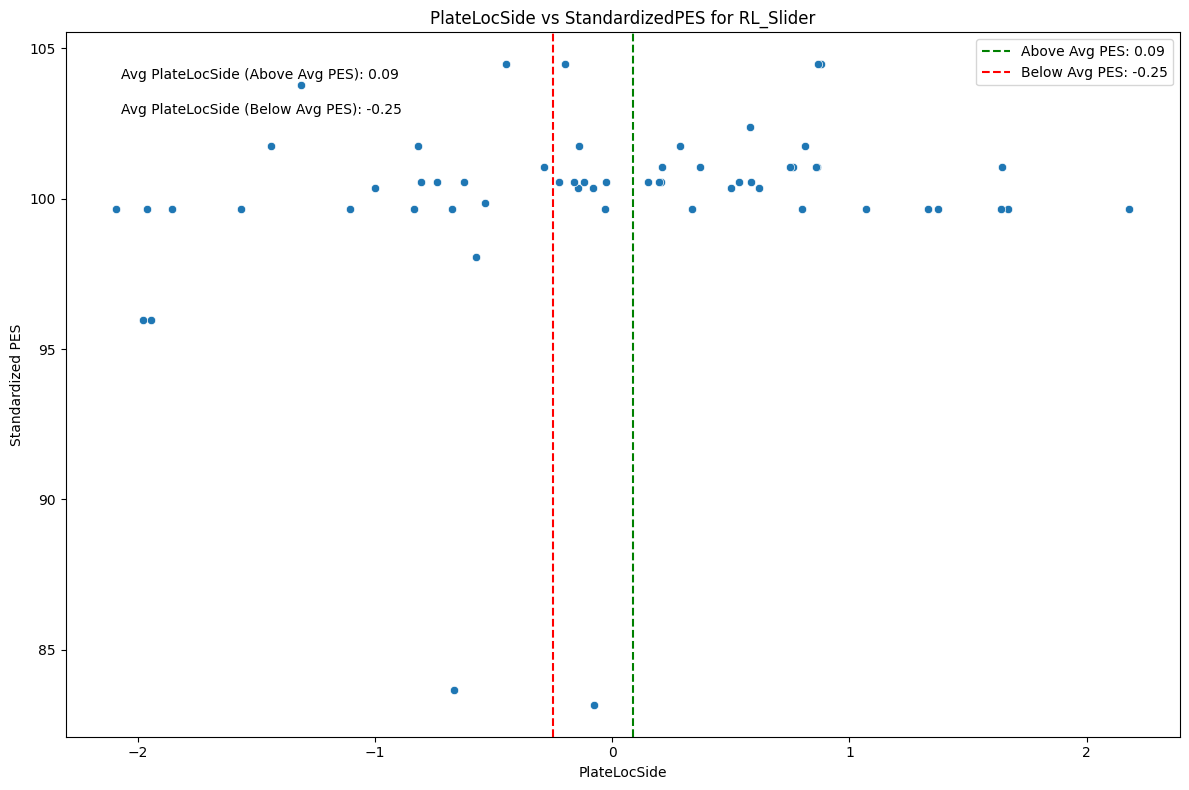

In [23]:
# Width Location
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RL_Slider']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='PlateLocSide', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['PlateLocSide'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['PlateLocSide'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('PlateLocSide vs StandardizedPES for RL_Slider')
plt.xlabel('PlateLocSide')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg PlateLocSide (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg PlateLocSide (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

Seen from the height and width graphs where Standardized PES = 96ish, these balls were lowish and inside, which is where I thought would be a good location but maybe not so much in hindsight since hte hitter can track the ball coming from out to in. Instead, front door sliders may actually be a good pitch to invest in since hitters give up on the pitch being too outside, then the slider bends in to get the strike. If you can combine keeping the ball on the outer 1/3-1/4th of the plate, height does not matter as much as long as the pitch catches the corner.

#### Righty-Lefty Changeup

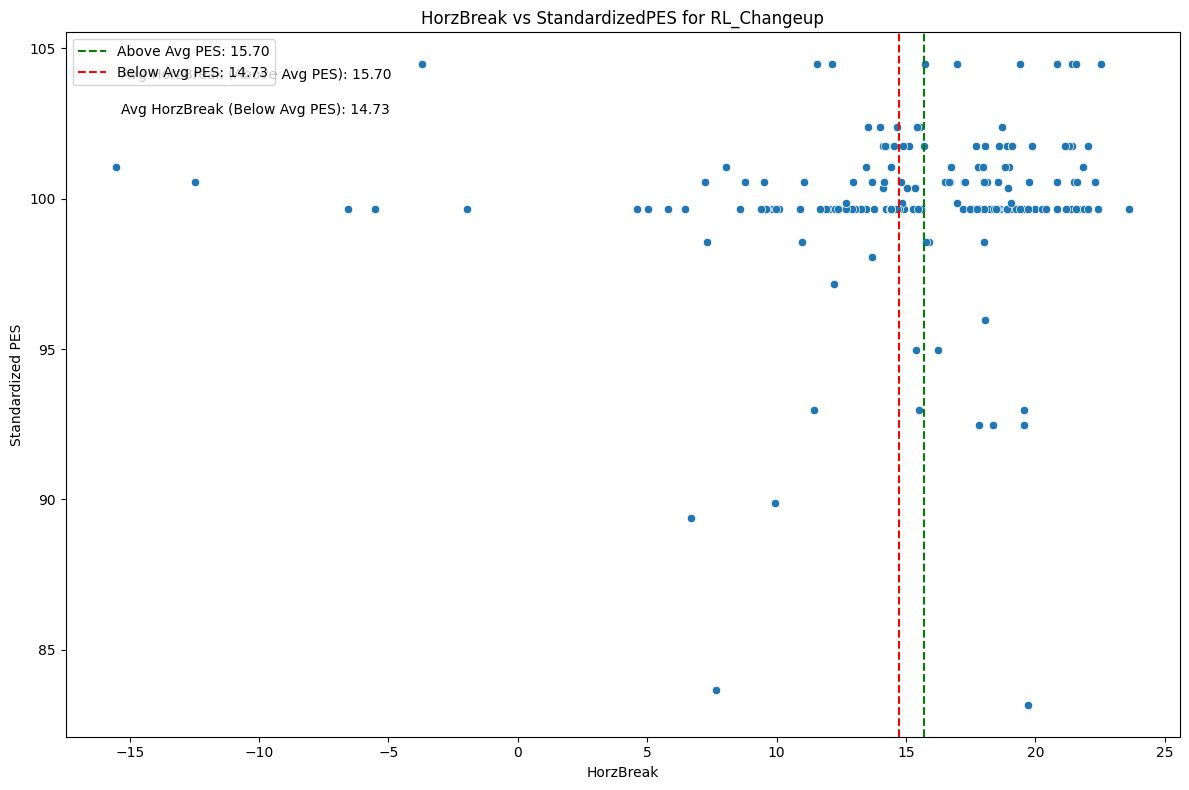

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RL_Changeup']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='HorzBreak', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['HorzBreak'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['HorzBreak'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('HorzBreak vs StandardizedPES for RL_Changeup')
plt.xlabel('HorzBreak')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg HorzBreak (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg HorzBreak (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

Hitters are not touching changeups with +20in of horizontal movement.

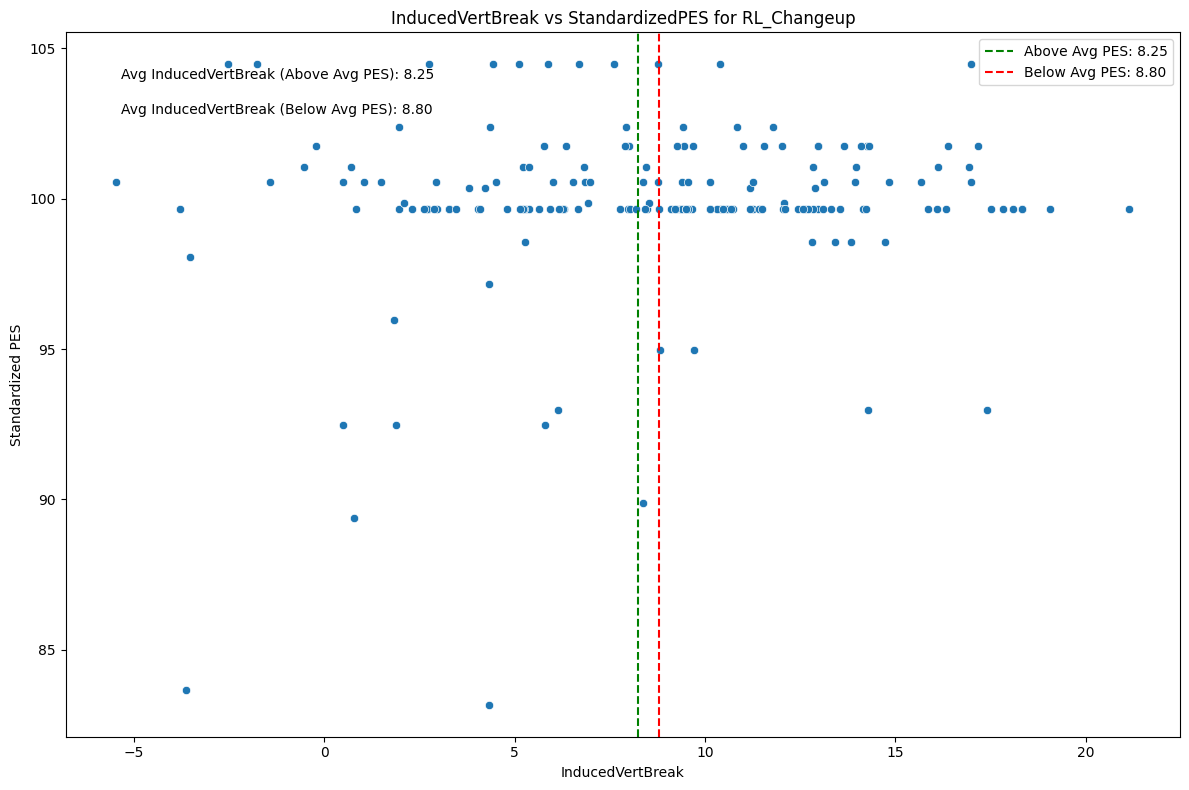

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RL_Changeup']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='InducedVertBreak', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['InducedVertBreak'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['InducedVertBreak'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('InducedVertBreak vs StandardizedPES for RL_Changeup')
plt.xlabel('InducedVertBreak')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg InducedVertBreak (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg InducedVertBreak (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

Quite counter intuituve, the changeups that play more like slow fastballs (right of the red line) have had better results than pitches I would generally consider to be better. Changeups seem to have a correlation in success with the similarity to the fastball instead of how good is this pitch on its own? This is probably due to the hitters' ability to differenciate the pitch to the fastball within the window of time.

#### Righty-Lefty Sinker

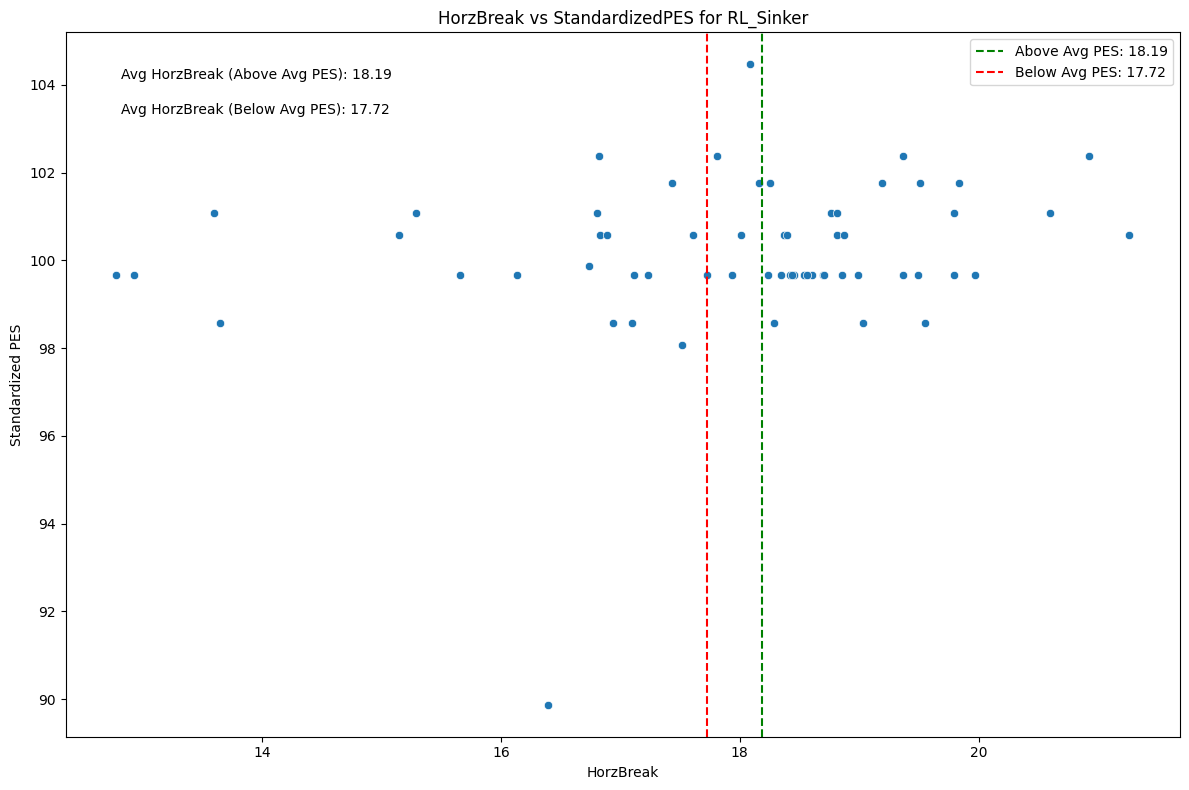

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RL_Sinker']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='HorzBreak', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['HorzBreak'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['HorzBreak'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('HorzBreak vs StandardizedPES for RL_Sinker')
plt.xlabel('HorzBreak')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg HorzBreak (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg HorzBreak (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

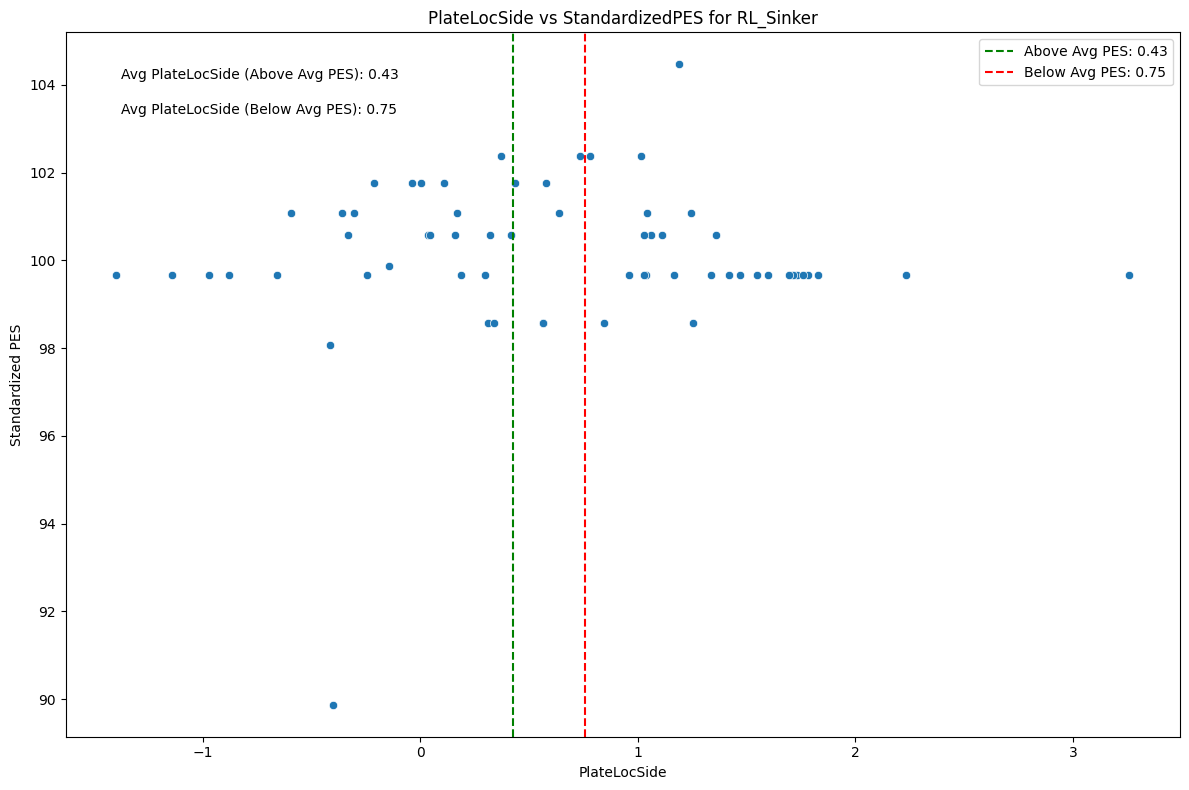

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['RL_Sinker']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='PlateLocSide', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['PlateLocSide'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['PlateLocSide'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('PlateLocSide vs StandardizedPES for RL_Sinker')
plt.xlabel('PlateLocSide')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg PlateLocSide (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg PlateLocSide (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

Similarly to the slider, ironically, this pitch seems to excel overall which I would not relaly expect, but it seems to thrive specifically on the outer 1/3-1/4th of hte plate. This pitch should not leak over the middle of hte plate (shown with the homer down below) as the pitch would hten run into the bat of the hitter. Opposite of the slider, start this pitch middle-1/3rd and have it run off the plate to generate swings and misses.

#### Left-Righty Fastball (Vertical Approach Angle)

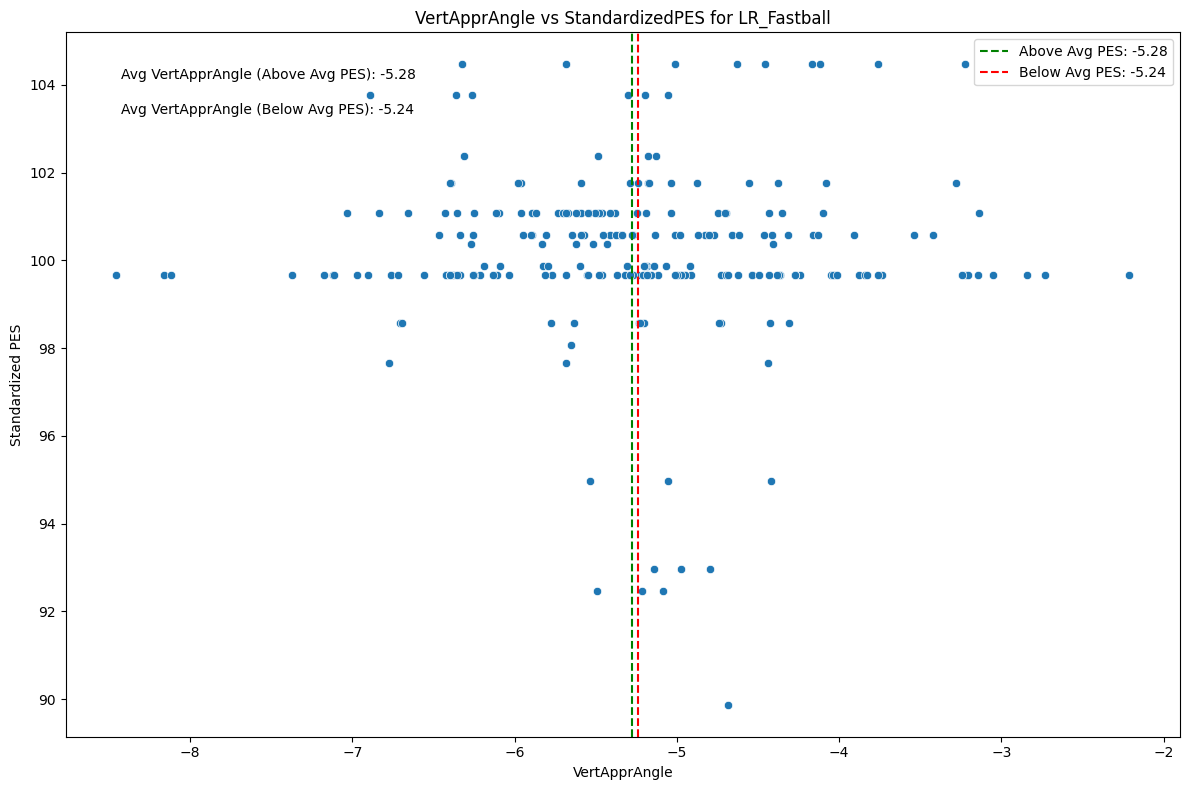

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['LR_Fastball']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='VertApprAngle', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['VertApprAngle'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['VertApprAngle'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('VertApprAngle vs StandardizedPES for LR_Fastball')
plt.xlabel('VertApprAngle')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg VertApprAngle (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg VertApprAngle (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

Vertical Approach Angle seems to be a better indicator of success than IVB. Not one way is better than the other, but below 6 looks to result in largely weak contact and above -4 results in swing and miss.

#### Lefty-Righty Changeup

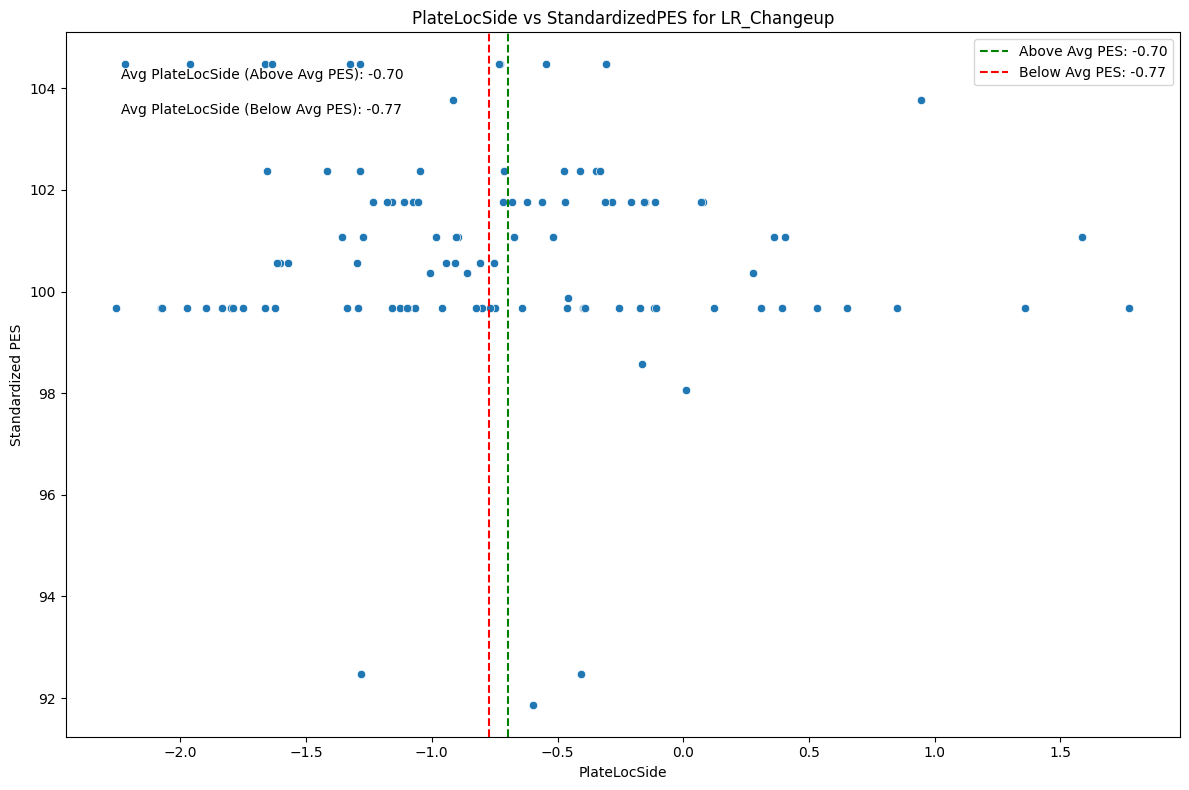

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['LR_Changeup']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='PlateLocSide', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['PlateLocSide'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['PlateLocSide'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('PlateLocSide vs StandardizedPES for LR_Changeup')
plt.xlabel('PlateLocSide')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg PlateLocSide (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg PlateLocSide (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

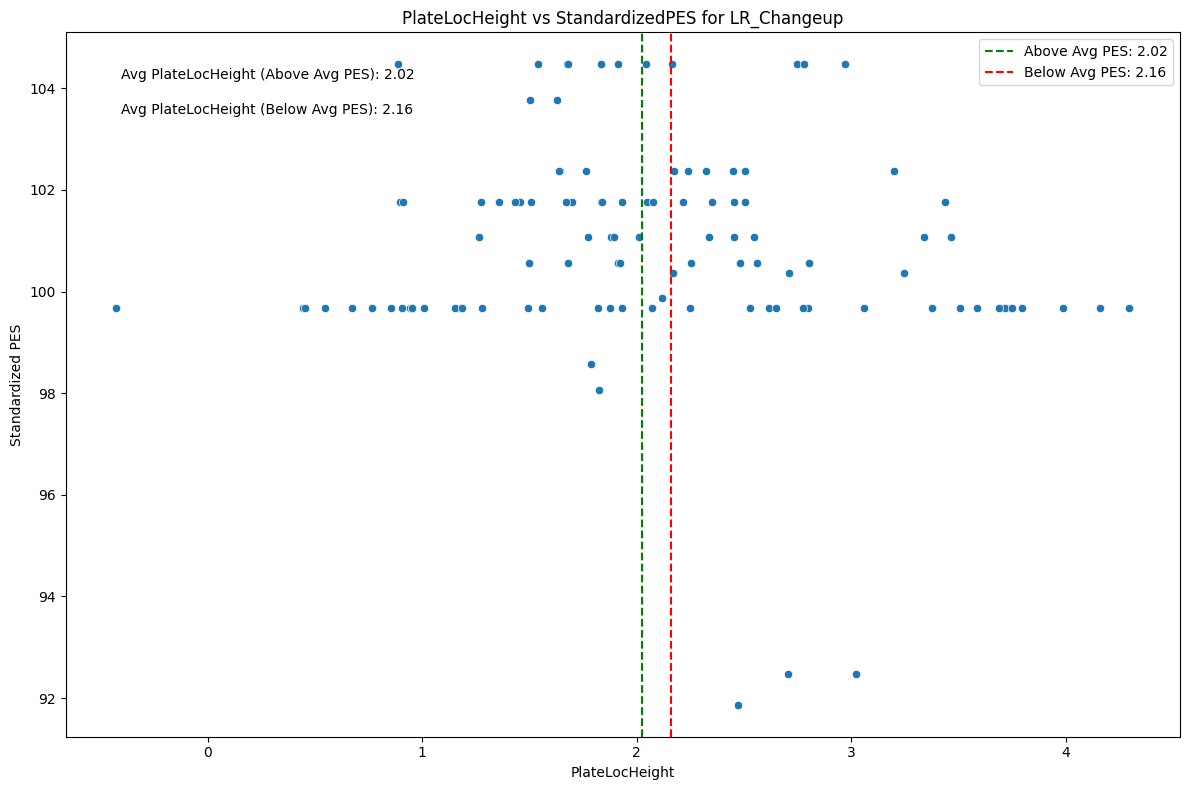

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['LR_Changeup']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='PlateLocHeight', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['PlateLocHeight'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['PlateLocHeight'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('PlateLocHeight vs StandardizedPES for LR_Changeup')
plt.xlabel('PlateLocHeight')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg PlateLocHeight (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg PlateLocHeight (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

Based off both the height and width locations, all three home runs came from more or less the same location. However, we can see that the pitch itself is a pretty consistent pitch that is generally very effective and positive in many locations, most particularly located low and outside (as expected).

#### Lefty-Lefty Fastball

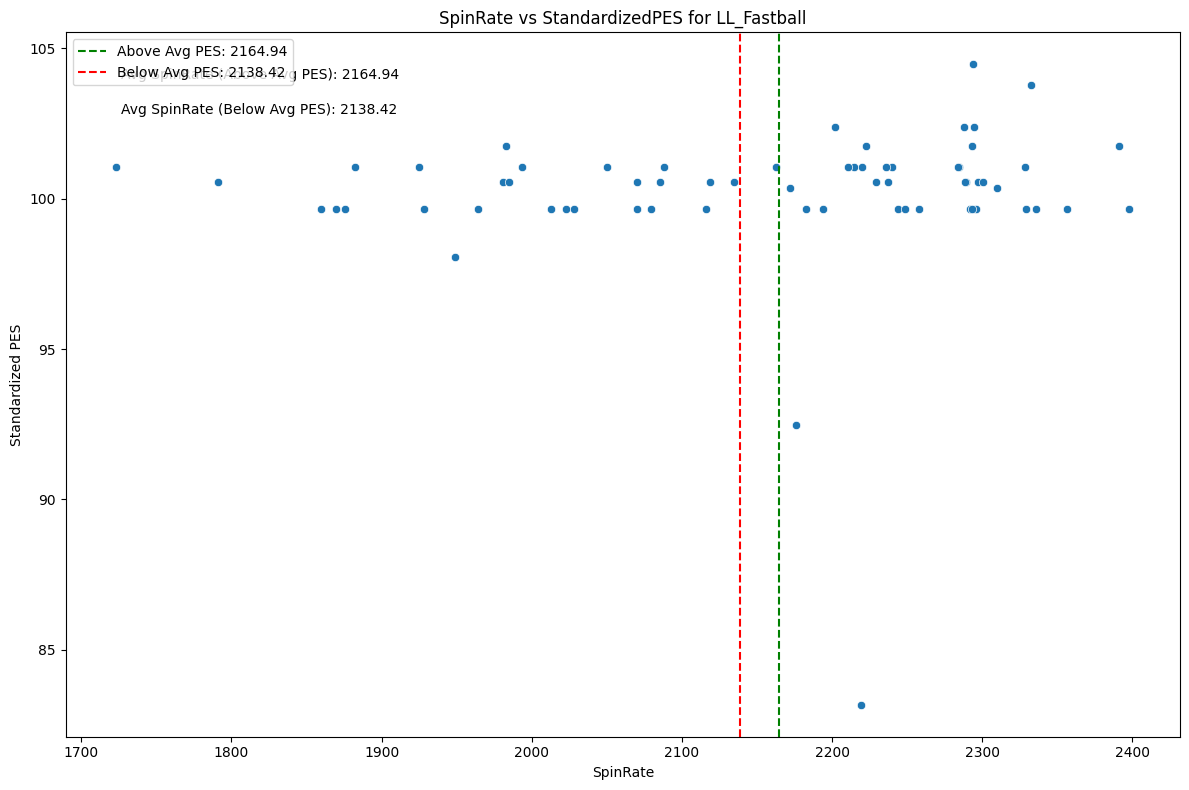

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['LL_Fastball']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='SpinRate', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['SpinRate'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['SpinRate'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('SpinRate vs StandardizedPES for LL_Fastball')
plt.xlabel('SpinRate')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg SpinRate (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg SpinRate (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

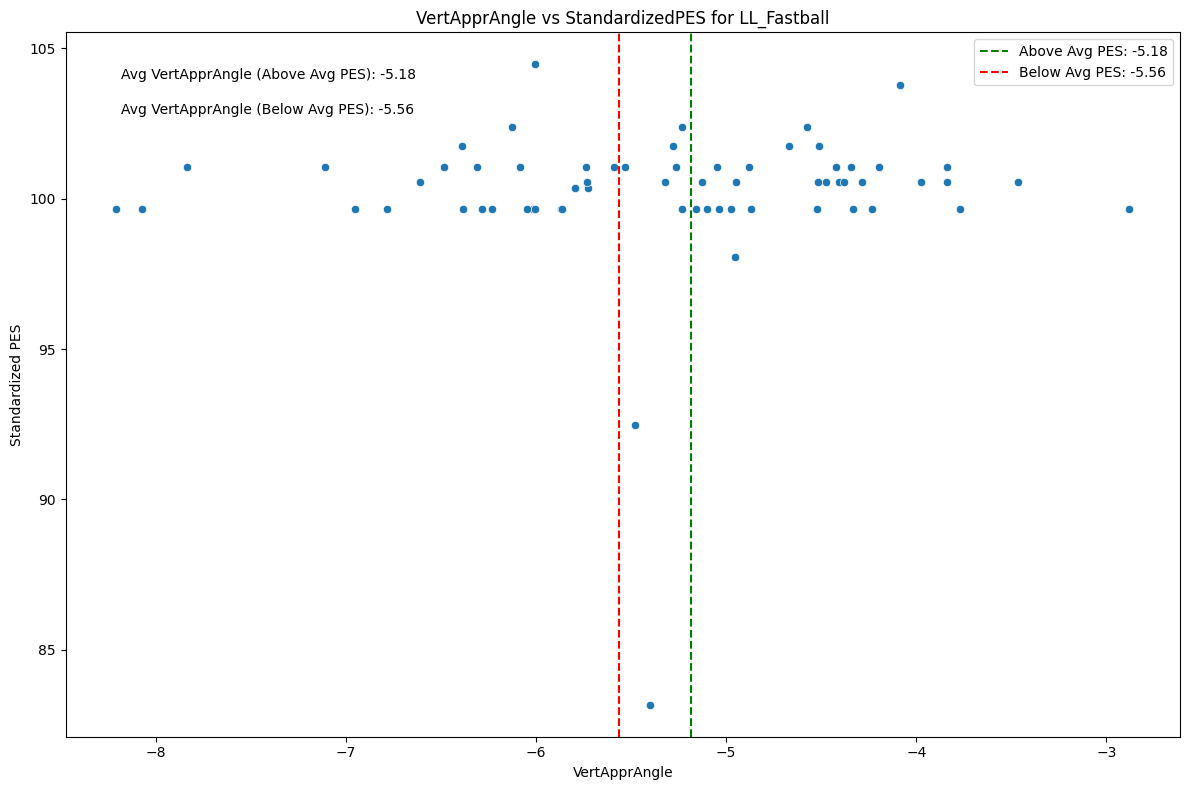

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['LL_Fastball']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='VertApprAngle', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['VertApprAngle'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['VertApprAngle'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('VertApprAngle vs StandardizedPES for LL_Fastball')
plt.xlabel('VertApprAngle')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg VertApprAngle (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg VertApprAngle (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

The few data points that we have give us a clear image why LL matchups are so sought after in lower level baseball since this matchup heavily faces the pitcher. LHH do not see LHP as frequently as RHP, making many of these pitches very effective (+2250 RPM and above -5 VAA).

#### Lefty-Lefty Slider

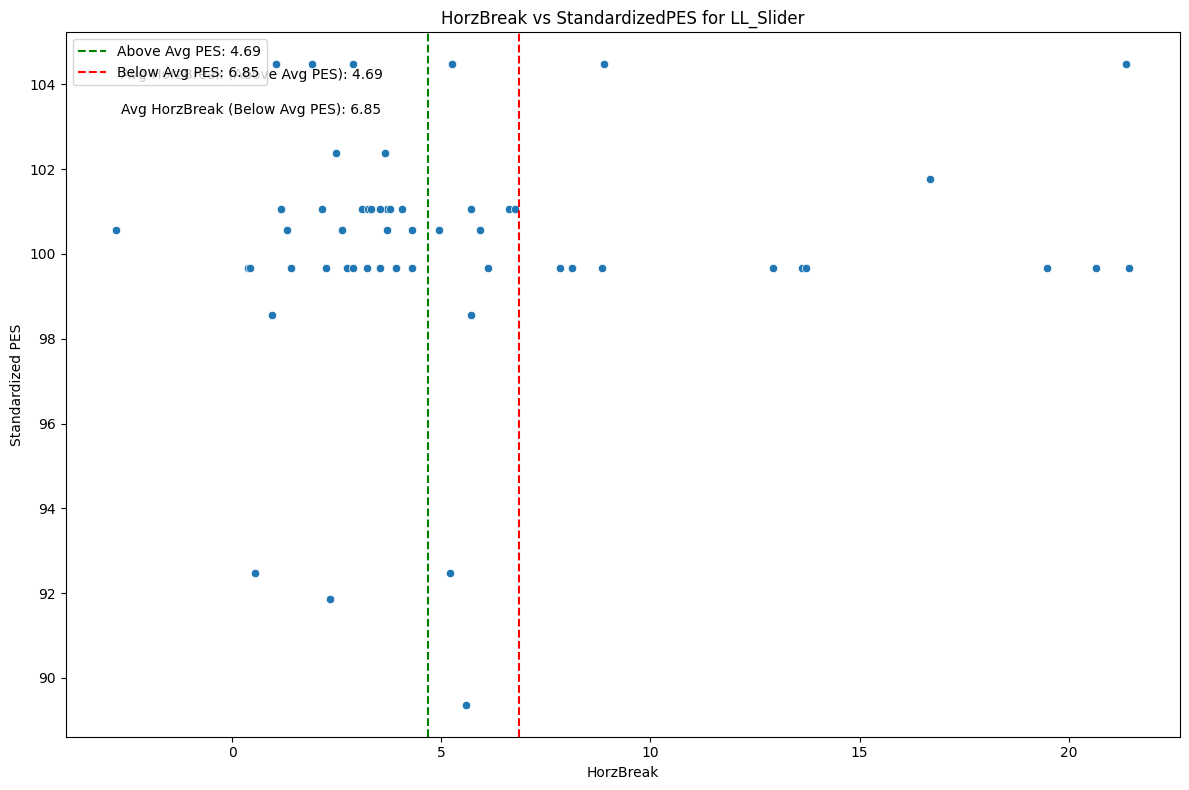

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['LL_Slider']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='HorzBreak', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['HorzBreak'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['HorzBreak'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('HorzBreak vs StandardizedPES for LL_Slider')
plt.xlabel('HorzBreak')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg HorzBreak (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg HorzBreak (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

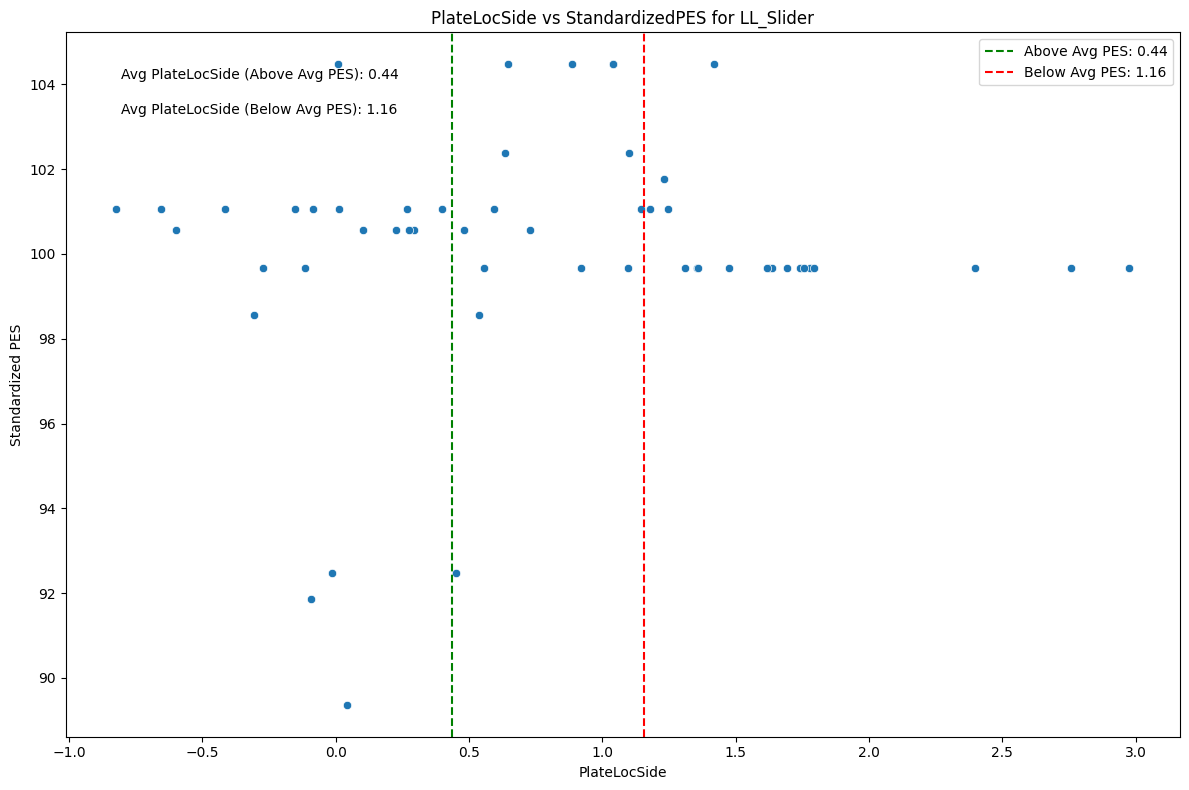

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = subset_dfs['LL_Slider']
plt.figure(figsize=(12, 8))

sns.scatterplot(x='PlateLocSide', y='StandardizedPES', data=df)

avg_pes = df['StandardizedPES'].mean()
above_avg = df[df['StandardizedPES'] > avg_pes]['PlateLocSide'].mean()
below_avg = df[df['StandardizedPES'] <= avg_pes]['PlateLocSide'].mean()
plt.axvline(x=above_avg, color='g', linestyle='--', label=f'Above Avg PES: {above_avg:.2f}')
plt.axvline(x=below_avg, color='r', linestyle='--', label=f'Below Avg PES: {below_avg:.2f}')

plt.title('PlateLocSide vs StandardizedPES for LL_Slider')
plt.xlabel('PlateLocSide')
plt.ylabel('Standardized PES')
plt.legend()
plt.text(0.05, 0.95, f'Avg PlateLocSide (Above Avg PES): {above_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')
plt.text(0.05, 0.90, f'Avg PlateLocSide (Below Avg PES): {below_avg:.2f}', transform=plt.gca().transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

From these two graphs, we can conclude that this pitch is very effective since there is a clear demarcation from where pitches of htis nature get hit and which pitches do not get hit. Sweeping Sliders (+7 inches of HorzBreak devastate LHH). Likewise, keep these pitches on the outer 1/3 of the plate, once they leak to the middle htey become drastically ineffective.

# Final Conclusions


* The scope of this project is currently limited due to the finite amount of datapoints that we have for each pitch type matchup when subsetted for handedness.
* Using this code, but extrapolating the amount of datapoints that we have using all qualified MLB pitchers might give a more accurate picture of relationships between variables and PES.
* This would eliminate any bias we have from the current data we have because everything will be mixed in: high level and low level pitchers and hitters alike of every handedness.
* Alternatively, we would need at least a seasons worth of UVA game data to base a model of this magnitude on.


## Pitch Specific Conclusions
*   RR_Sinker is kind of a steady pitch, (Low Volume, use with caution) not hit really often but also is not often being whiffed at, mainly taken for strikes
